# Set up file 

In [1]:
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable  
import matplotlib
import scipy
import scipy.interpolate
import sys
sys.path.insert(0, '/srv/ccrc/data06/z5145948/Python/python_from_R/Holocene/sampled_models/plotting_files/')
from plott import plott
import scipy.interpolate
from mpl_toolkits.basemap import Basemap
matplotlib.use('agg')
from Cross_section import Cross_section
from Proxy_graph_masked import Proxy_graph
import Config
# from Map_plot import Map_plot
from collections import Counter
import scipy.stats as stats
from pylab import *
rcParams['legend.numpoints'] = 1
from matplotlib.ticker import MaxNLocator
import time
from IPython import embed
import os
from matplotlib import gridspec
import re
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import lines
import matplotlib as mpl

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{wasysym}',
    r'\usepackage{textcomp}']

fontsize = 18

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1200

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

%matplotlib inline

/home/z5145948/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)
/home/z5145948/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Define the d13C contour characterisics
cmap = 'RdYlGn'#'gist_rainbow'
d13C_color_min = -0.5
d13C_color_max = 1.25

# d13C_color_levels = np.arange(d13C_color_min, d13C_color_max, (d13C_color_max-(d13C_color_min))/50)

# Import standardised latitudes and depths
lat_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/latitude_levels.csv', delimiter=',')
dep_standardised = np.genfromtxt('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/depth_levels.csv', delimiter=',')
dep = dep_standardised
lat = lat_standardised  

# The length of time of each slice
slice_width = 1

# tolerance around average depth deviation
tol = 300
dividing_depth = 2500

# File saving location
overleaf_loc = '/home/z5145948/Dropbox/Apps/Overleaf/Paper_2/Figures'


In [3]:
####3 reading data function

def read_data(folder):

    # Import simulation details (summary) as dataframe
    summary = pd.read_csv(folder + '_summary.txt', delimiter = ' ')

    # Import simulation outputs
    fh = Dataset(folder + 'output.nc')
    proxy_simulations = fh.variables['var1_1'][:] 

    # Import samples (proxy data)
    samples = pd.read_csv( folder + '_samples.txt', delimiter = ' ')

    # Drop all unnecessary rows in summary
    summary = summary.drop(['type', 'Row.names', 'reps', 'model', 'dataset', 'filename', 'success.rate'], axis = 1)

    # Convert run.no to netcdf file index
    summary['run.no'] = summary['run.no'] - 1
    samples['run.no'] = samples['run.no'] - 1
    
    return(proxy_simulations, samples, summary)

In [4]:
# Define a function for reading and including cores that are in the Oliver compilation but not in the Peterson data set

def Oliver_cores(minn, maxx):
    import pandas as pd
    import numpy as np
    folder_location = '/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/'
    file_mat = ['GeoB4403_2.txt',
             'GeoB1028_5.txt',
             'GeoB2109_1.txt',
             'GeoB3801_6.txt',
             'V22_38.txt',
             'V28_56.txt',
             'V27_20.txt',
             'RC12_339.txt',
             'V32_128.txt',
             'GIK16772_1.txt',
             'MD96_2080.txt',
             'MD06_3018.txt',
             'NEAP18K.txt',
             'KNR140_37JPC.txt']


    location = ['Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Atlantic,','Indian,','Pacific,','Atlantic,','Atlantic,','Pacific,','Atlantic,','Atlantic,']

    oliver_data = []

    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                oliver_data.append(location[i] + line)
        i += 1

    df = pd.DataFrame([sub.split(",") for sub in oliver_data])

    df.columns = ['Location','Core','Lat','Lon','Dep','Core depth','age','Species','pl1','pl2','d18O benthic','d13C']

    df = df[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df['d13C'] = [i.rstrip() for i in df['d13C']]

    df = df[df['age'].astype(float) > float(minn)]
    df = df[df['age'].astype(float) < float(maxx)]

    ################################# other data                                                                                                                                                                                                                                  

    file_mat = ['CH69_K09.txt',
    'MD03_2664.txt',
    'MD95_2042.txt',
    'U1308.txt',
    'ODP1063.txt']

    locations = ['CH69_K09\tAtlantic\t41.75\t-47.35\t4100\t',
              'MD03_2664\tAtlantic\t57.439000\t-48.605800\t3442.0\t',
              'MD95_2042\tAtlantic\t37.799833\t-10.166500\t3146.0\t',
              'U1308\tAtlantic\t49.877760\t-24.238110\t3871.0\t',
              'ODP1063\tAtlantic\t33.683333\t-57.616667\t4584\t']

    other_data = []
    i = 0

    while i < len(file_mat):
        with open(folder_location + file_mat[i]) as f:
            for line in f:
                other_data.append(locations[i]+line)
        i += 1

    df2 = pd.DataFrame([sub.split("\t") for sub in other_data])

    df2.columns = ['Core','Location','Lat','Lon','Dep','Core Depth','age','d13C']

    df2 = df2[['Core','Location','Lat','Lon','Dep','d13C','age']]

    df2['d13C'] = [i.rstrip() for i in df2['d13C']]

    df2 = df2[df2['age'].astype(float) > float(minn)]
    df2 = df2[df2['age'].astype(float) < float(maxx)]

    results = pd.concat([df, df2])

    results = results[results['d13C'] != '']

    results['d13C'] = results['d13C'].astype(float)
    results['Lat'] = results['Lat'].astype(float)
    results['Lon'] = results['Lon'].astype(float)
    results['Dep'] = results['Dep'].astype(float)

    return(results)    
    

In [5]:

def pl_cores(minn, maxx):

    names = ['Core', 'Location', 'Lat', 'Lon', 'Dep']

    # Read in the data
    indopac = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/indopac_core_data_LS16.txt", delimiter = ',', names = names)
    atl = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/atl_core_data_LS16.txt", delimiter = ',', names = names)
    add = pd.read_table("/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/Additional_core_locations.txt", delimiter = ',', usecols = [0, 1, 2, 3, 4], names = names)

    # Join all into a single dataframe
    df = indopac.append(atl)
    df = df.append(add)
    df = df.reset_index(drop = True)

    df['d18O names'] = df['Core'] + '_ageLS16.txt'
    df['d13C names'] = df['Core'] + '_d13C.txt'

    # Loop over the dataset and interpolate each core
    i = 0
    results_dict = {}

    while i < df.count()[0]:

        try:
            df_d18O = pd.read_table('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/' + df.loc[i]['d18O names'], delim_whitespace = True, names = ['depth', 'age'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue
        try:
            df_d13C = pd.read_table('/srv/ccrc/data06/z5145948/Moving_water_mass/Data/Core_files/' + df.loc[i]['d13C names'], delim_whitespace = True, names = ['depth', 'd13C'], skip_blank_lines = True, na_values = 'NAN')
        except:
            i += 1
            continue

        df_d18O = df_d18O.dropna(subset = ['age']) 
        df_d13C = df_d13C.dropna(subset = ['d13C'])

        df_d18O = df_d18O.reset_index(drop = True)
        df_d13C = df_d13C.reset_index(drop = True)

        interp = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = True)
        try:
            df_d13C['age'] = interp(df_d13C['depth'])
        except:
            try:
                interp2 = scipy.interpolate.interp1d(df_d18O['depth'], df_d18O['age'], bounds_error = False)
                df_d13C['age'] = interp2(df_d13C['depth'])
            except:
                i += 1
                continue

        df_d13C = df_d13C.dropna(subset = ['age'])
        df_d13C = df_d13C.reset_index(drop = True)

        df_d13C = df_d13C[df_d13C['age'] > minn]
        df_d13C = df_d13C[df_d13C['age'] < maxx]

        if len(df_d13C) > 0:
            df_results = df.drop(['d18O names', 'd13C names'], axis = 1)
            df_results = df_results.loc[df_results.index.repeat(len(df_d13C))].loc[[i]]

            df_d13C = df_d13C.drop(['depth'], axis = 1)

            df_results = df_results.reset_index(drop = True).join(df_d13C.reset_index(drop = True))
            results_dict.update({
                df_results.Core[0] : df_results.drop(['Core'], axis = 1)
            })

        i += 1
        
    df_results = pd.concat(results_dict).reset_index()
    df_results = df_results.rename(columns = {'level_0' : 'Core'})
    df_results = df_results.drop(['level_1'], axis = 1)

    return(df_results)
    

In [6]:
# ################## read in the oliver data using the predefined function

# Age range to look over
Hol_min = 2
Hol_max = 8

df_pl = pl_cores(Hol_min, Hol_max)

df_oliver = Oliver_cores(Hol_min, Hol_max)

###################3 join the dataframes

df_results = df_pl.append(df_oliver)
  
#################### get only the atlantic cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df = df.reset_index(drop = True)
df['age'] = df.age.astype(float)

# Slice the data
lower = np.arange(Hol_min, Hol_max, 1)
upper = np.arange(Hol_min+1, Hol_max+1, 1)

proxy_compilation = {}

for low, up in zip(lower, upper):
    df_slice = df[(df['age'] >= low) & (df['age'] < up)]
    grouped_slice = df_slice.groupby(['Lat', 'Lon', 'Dep'])

    slice_averaged = {}

    i = 0
    for key, group in grouped_slice:
        group_averaged = group.mean()
        group_count = group.count()
        group_averaged['count'] = group_count['d13C']
        slice_averaged.update({
            i : pd.DataFrame(group_averaged)
        })
        i += 1

    slice_averaged = pd.concat(slice_averaged, axis=1).T.reset_index(drop=True)
    slice_averaged = slice_averaged.drop(['age'],axis=1)
    
    proxy_compilation.update({
        low : slice_averaged.T
    })

proxy_compilation = pd.concat(proxy_compilation,axis=1).T.reset_index(drop=False)
proxy_compilation = proxy_compilation.drop(columns=['level_1'],axis=1)
proxy_compilation = proxy_compilation.rename(columns={'level_0' : 'lower', 'Dep' : 'Ocean_depth'})
Hol_samples = proxy_compilation
Hol_deeper_samples = Hol_samples[Hol_samples['Ocean_depth'] > dividing_depth]
Hol_shallower_samples = Hol_samples[Hol_samples['Ocean_depth'] < dividing_depth]


/home/z5145948/anaconda3/lib/python3.6/site-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '2.6.2' or newer of 'numexpr' (version '2.6.1' currently installed).
  warnings.warn(msg, UserWarning)


In [7]:
# ################## read in the oliver data using the predefined function

# Age range to look over
LIG_min = 118
LIG_max = 130

df_pl = pl_cores(LIG_min, LIG_max)

df_oliver = Oliver_cores(LIG_min, LIG_max)

###################3 join the dataframes

df_results = df_pl.append(df_oliver)
  
#################### get only the atlantic cores

df = df_results.reset_index(drop = True)
df['Dep'] = abs(df['Dep'])

df = df.reset_index(drop = True)
df['age'] = df.age.astype(float)

# Slice the data
lower = np.arange(LIG_min, LIG_max, 1)
upper = np.arange(LIG_min+1, LIG_max+1, 1)

proxy_compilation = {}

for low, up in zip(lower, upper):
    df_slice = df[(df['age'] >= low) & (df['age'] < up)]
    grouped_slice = df_slice.groupby(['Lat', 'Lon', 'Dep'])

    slice_averaged = {}

    i = 0
    for key, group in grouped_slice:
        group_averaged = group.mean()
        group_count = group.count()
        group_averaged['count'] = group_count['d13C']
        slice_averaged.update({
            i : pd.DataFrame(group_averaged)
        })
        i += 1

    slice_averaged = pd.concat(slice_averaged, axis=1).T.reset_index(drop=True)
    slice_averaged = slice_averaged.drop(['age'],axis=1)
    
    proxy_compilation.update({
        low : slice_averaged.T
    })

proxy_compilation = pd.concat(proxy_compilation,axis=1).T.reset_index(drop=False)
proxy_compilation = proxy_compilation.drop(columns=['level_1'],axis=1)
proxy_compilation = proxy_compilation.rename(columns={'level_0' : 'lower', 'Dep' : 'Ocean_depth'})
LIG_samples = proxy_compilation
LIG_deeper_samples = LIG_samples[LIG_samples['Ocean_depth'] > dividing_depth]
LIG_shallower_samples = LIG_samples[LIG_samples['Ocean_depth'] < dividing_depth]


# Regional Analysis

In [8]:
# Set up the graphs

total_graph_width = 17
gap = 1
width_hol = float((Hol_max - Hol_min + 2*gap))
width_lig = float((LIG_max - LIG_min + 2*gap))


In [9]:
# NE Atlantic

NE_lat_min = 41
NE_lat_max = 58
NE_lon_min = -32
NE_lon_max = -15

# Namibian coast

NB_lat_min = -28
NB_lat_max = -18
NB_lon_min = 4
NB_lon_max = 15

# Equatorial Atlantic

MA_lat_min = -7
MA_lat_max = 3
MA_lon_min = -18
MA_lon_max = -5

# Galapagos region

GA_lat_min = -5
GA_lat_max = 6
GA_lon_min = -98
GA_lon_max = -82

# get dataframes of data that are in the selected regions to compare across the Holocene and the LIG

def area_filter(df, lon_min, lon_max, lat_min, lat_max):
    
    df = df[(df.Lon > lon_min) & (df.Lon < lon_max) & (df.Lat < lat_max) & (df.Lat > lat_min)]
    
    return(df)

NE_Hol_cores_deeper = area_filter(Hol_deeper_samples, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max)
NB_Hol_cores_deeper = area_filter(Hol_deeper_samples, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max)
MA_Hol_cores_deeper = area_filter(Hol_deeper_samples, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max)
GA_Hol_cores_deeper = area_filter(Hol_deeper_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)

NE_LIG_cores_deeper = area_filter(LIG_deeper_samples, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max)
NB_LIG_cores_deeper = area_filter(LIG_deeper_samples, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max)
MA_LIG_cores_deeper = area_filter(LIG_deeper_samples, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max)
GA_LIG_cores_deeper = area_filter(LIG_deeper_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)

NE_Hol_cores_shallower = area_filter(Hol_shallower_samples, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max)
NB_Hol_cores_shallower = area_filter(Hol_shallower_samples, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max)
MA_Hol_cores_shallower = area_filter(Hol_shallower_samples, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max)
GA_Hol_cores_shallower = area_filter(Hol_shallower_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)

NE_LIG_cores_shallower = area_filter(LIG_shallower_samples, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max)
NB_LIG_cores_shallower = area_filter(LIG_shallower_samples, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max)
MA_LIG_cores_shallower = area_filter(LIG_shallower_samples, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max)
GA_LIG_cores_shallower = area_filter(LIG_shallower_samples, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max)



# Regional Summary Plot

In [10]:
NE_Hol_cores = pd.concat([NE_Hol_cores_deeper, NE_Hol_cores_shallower])
NB_Hol_cores = pd.concat([NB_Hol_cores_deeper, NB_Hol_cores_shallower])
MA_Hol_cores = pd.concat([MA_Hol_cores_deeper, MA_Hol_cores_shallower])
GA_Hol_cores = pd.concat([GA_Hol_cores_deeper, GA_Hol_cores_shallower])

NE_LIG_cores = pd.concat([NE_LIG_cores_deeper, NE_LIG_cores_shallower])
NB_LIG_cores = pd.concat([NB_LIG_cores_deeper, NB_LIG_cores_shallower])
MA_LIG_cores = pd.concat([MA_LIG_cores_deeper, MA_LIG_cores_shallower])
GA_LIG_cores = pd.concat([GA_LIG_cores_deeper, GA_LIG_cores_shallower])


In [11]:
from PIL import Image

def rotate(image_path, degrees_to_rotate, saved_location):
    """
    Rotate the given photo the amount of given degreesk, show it and save it
    @param image_path: The path to the image to edit
    @param degrees_to_rotate: The number of degrees to rotate the image
    @param saved_location: Path to save the cropped image
    """

    image_obj = Image.open(image_path)
    rotated_image = image_obj.rotate(degrees_to_rotate)
    rotated_image.save(saved_location)
    

In [12]:
# Function for plotting box regions

def box_plot(ax, lon_min, lon_max, lat_min, lat_max, col):
    lw = 4
    ax.plot([lon_min, lon_max], [lat_min, lat_min],c=col,lw=lw)
    ax.plot([lon_min, lon_max], [lat_max, lat_max],c=col,lw=lw)
    ax.plot([lon_min, lon_min], [lat_min, lat_max],c=col,lw=lw)
    ax.plot([lon_max, lon_max], [lat_min, lat_max],c=col,lw=lw)

NE_Hol_color = 'm'
NE_LIG_color = 'r'
MA_Hol_color = 'y'
MA_LIG_color = 'g'
NB_Hol_color = 'c'
NB_LIG_color = 'b'
GA_Hol_color = 'w'
GA_LIG_color = '0.5'

region_colors = [NE_Hol_color,NE_LIG_color,MA_Hol_color,MA_LIG_color,NB_Hol_color,NB_LIG_color,GA_Hol_color,GA_LIG_color]


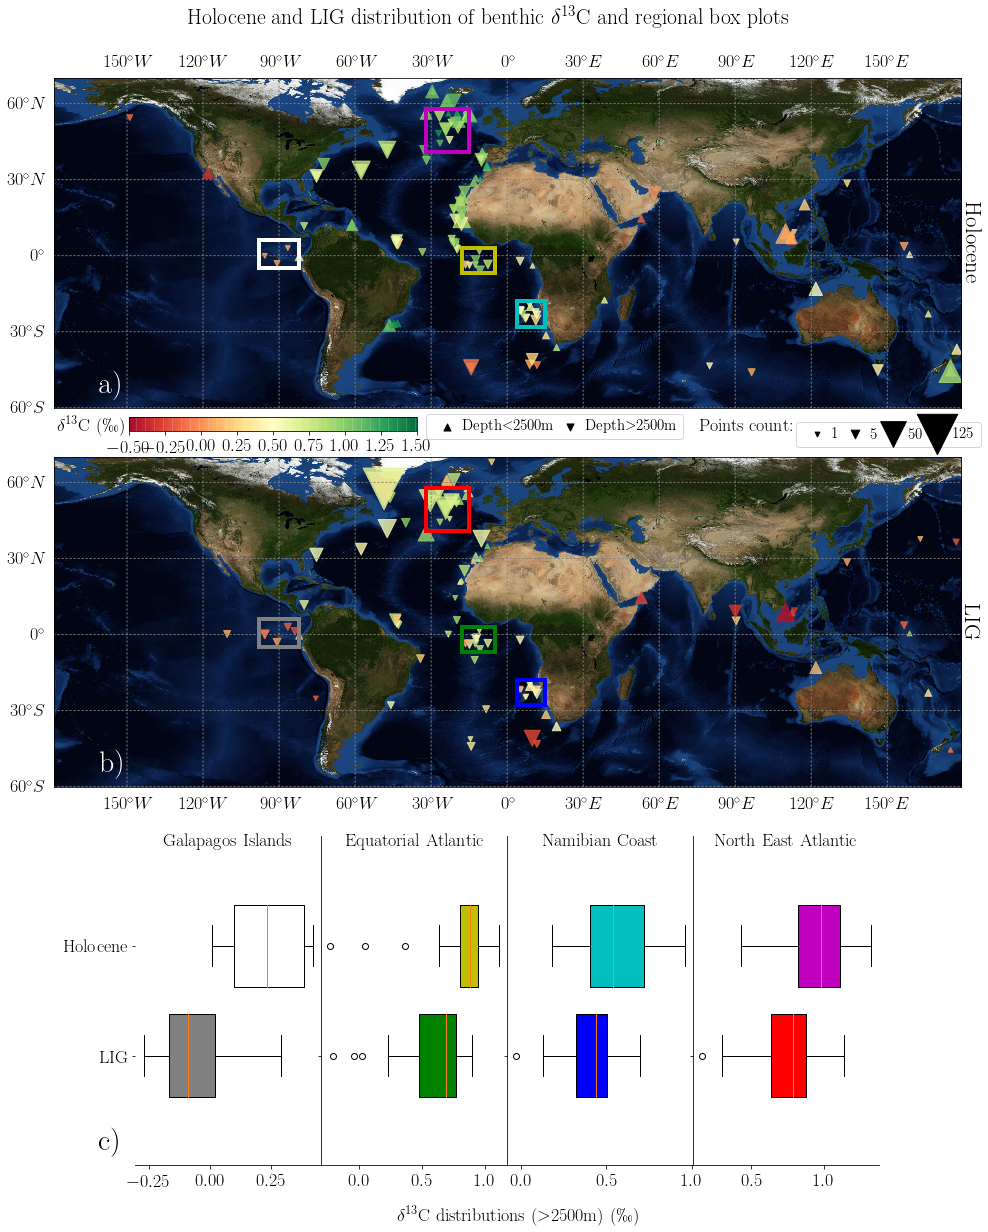

In [13]:
# Get the bounds for the scatter graphs and box plots

vmin = -0.5#np.min([np.min(Hol_cores_averaged.d13C),np.min(LIG_cores_averaged.d13C)])
vmax = 1.5#np.min([np.max(Hol_cores_averaged.d13C),np.max(LIG_cores_averaged.d13C)])

point_size_multiplier = 13
point_size_addition = 10

# plot it

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(wspace=0.0,hspace=0.15)

axHC = plt.subplot2grid((3,6),(0,0),colspan=6)
axLC = plt.subplot2grid((3,6),(1,0),colspan=6)

axStat4 = plt.subplot2grid((3,6),(2,1))
axStat2 = plt.subplot2grid((3,6),(2,2))
axStat3 = plt.subplot2grid((3,6),(2,3))
axStat1 = plt.subplot2grid((3,6),(2,4))

alpha = 0.8
########### Holocene ###############

Hol_cores_averaged = Hol_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
Hol_cores_stdev = Hol_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

s1 = Hol_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).sum().reset_index()['count']
Hol_scatter = axHC.scatter(Hol_cores_averaged.Lon, Hol_cores_averaged.Lat, c=Hol_cores_averaged.d13C,
           s=s1*point_size_multiplier+point_size_addition,vmin=vmin,vmax=vmax,cmap=cmap,marker='^',alpha=alpha)

Hol_cores_averaged = Hol_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
Hol_cores_stdev = Hol_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

s2 = Hol_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).sum().reset_index()['count']
Hol_scatter = axHC.scatter(Hol_cores_averaged.Lon, Hol_cores_averaged.Lat, c=Hol_cores_averaged.d13C,
           s=s2*point_size_multiplier+point_size_addition,vmin=vmin,vmax=vmax,cmap=cmap,marker='v',alpha=alpha)


m = Basemap(ax = axHC, resolution = None, llcrnrlon = -179, urcrnrlon = 179, llcrnrlat = -60, urcrnrlat = 70)
m.bluemarble(scale=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,1,0],color='0.5',zorder=1)
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0],color='0.5',zorder=2)

################# Define regions

box_plot(axHC, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max,NE_Hol_color)
box_plot(axHC, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max,NB_Hol_color)
box_plot(axHC, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max,MA_Hol_color)
box_plot(axHC, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max,GA_Hol_color)


########### LIG ###############

LIG_cores_averaged = LIG_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
LIG_cores_stdev = LIG_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

s3 = LIG_shallower_samples.groupby(['Lat','Lon','Ocean_depth']).sum().reset_index()['count']
LIG_scatter = axLC.scatter(LIG_cores_averaged.Lon, LIG_cores_averaged.Lat, c=LIG_cores_averaged.d13C,
           s=s3*point_size_multiplier+point_size_addition,vmin=vmin,vmax=vmax,cmap=cmap,marker='^',alpha=alpha)

LIG_cores_averaged = LIG_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).mean().reset_index()
LIG_cores_stdev = LIG_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).std().reset_index()

s4 = LIG_deeper_samples.groupby(['Lat','Lon','Ocean_depth']).sum().reset_index()['count']
LIG_scatter = axLC.scatter(LIG_cores_averaged.Lon, LIG_cores_averaged.Lat, c=LIG_cores_averaged.d13C,
           s=s4*point_size_multiplier+point_size_addition,vmin=vmin,vmax=vmax,cmap=cmap,marker='v',alpha=alpha)


m = Basemap(ax = axLC, resolution = None, llcrnrlon = -179, urcrnrlon = 179, llcrnrlat = -60, urcrnrlat = 70)
m.bluemarble(scale=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,1],color='0.5',zorder=1)
m.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0],color='0.5',zorder=2)

###### define regions

box_plot(axLC, NE_lon_min, NE_lon_max, NE_lat_min, NE_lat_max,NE_LIG_color)
box_plot(axLC, NB_lon_min, NB_lon_max, NB_lat_min, NB_lat_max,NB_LIG_color)
box_plot(axLC, MA_lon_min, MA_lon_max, MA_lat_min, MA_lat_max,MA_LIG_color)
box_plot(axLC, GA_lon_min, GA_lon_max, GA_lat_min, GA_lat_max,GA_LIG_color)


################# 

# Boxplots

distance = 0.2

bp1 = axStat1.boxplot(NE_Hol_cores.d13C.values,positions=[0],patch_artist=True,vert=False)
bp2 = axStat1.boxplot(NE_LIG_cores.d13C.values,positions=[distance],patch_artist=True,vert=False)
bp3 = axStat2.boxplot(MA_Hol_cores.d13C.values,positions=[0],patch_artist=True,vert=False)
bp4 = axStat2.boxplot(MA_LIG_cores.d13C.values,positions=[distance],patch_artist=True,vert=False)
bp5 = axStat3.boxplot(NB_Hol_cores.d13C.values,positions=[0],patch_artist=True,vert=False)
bp6 = axStat3.boxplot(NB_LIG_cores.d13C.values,positions=[distance],patch_artist=True,vert=False)
bp7 = axStat4.boxplot(GA_Hol_cores.d13C.values,positions=[0],patch_artist=True,vert=False)
bp8 = axStat4.boxplot(GA_LIG_cores.d13C.values,positions=[distance],patch_artist=True,vert=False)

# fill with colors
for box,color in zip([bp1['boxes'],bp2['boxes'],bp3['boxes'],bp4['boxes'],bp5['boxes'],bp6['boxes'],bp7['boxes'],bp8['boxes']],
                     region_colors):
    for patch in box:
        patch.set_facecolor(color)


############################################### ###############################################
############################################### ###############################################
# Format the graph
############################################### ###############################################
############################################### ###############################################

##### Plot boundaries

axStat4.spines['left'].set_visible(False)
axStat1.spines['right'].set_visible(False)
axStat1.spines['top'].set_visible(False)
axStat2.spines['top'].set_visible(False)
axStat3.spines['top'].set_visible(False)
axStat4.spines['top'].set_visible(False)

###### Legends 

cbaxes = fig.add_axes([0.25, 0.635, 0.2, 0.01])  #hor position,vert position,hor width,vert width
cb = plt.colorbar(Hol_scatter,cax=cbaxes,orientation = 'horizontal')  
cbaxes.text(x=-0.25,y=0,s='$\delta^{13}$C ($\permil$)')

symb_up = axHC.scatter([],[],marker='^',c='k',s=50)
symb_down = axHC.scatter([],[],marker='v',c='k',s=50)

plt.legend([symb_up,symb_down],['Depth$<${}m'.format(dividing_depth),'Depth$>${}m'.format(dividing_depth)],
           ncol=2,handletextpad=0.01,columnspacing=0.01,bbox_to_anchor=[1.95,1.7,0,0],fontsize=15)

s1 = plt.scatter([],[],s=[1*point_size_multiplier+point_size_addition],marker='v',c='k')
s2 = plt.scatter([],[],s=[5*point_size_multiplier+point_size_addition],marker='v',c='k')
s3 = plt.scatter([],[],s=[50*point_size_multiplier+point_size_addition],marker='v',c='k')
s4 = plt.scatter([],[],s=[125*point_size_multiplier+point_size_addition],marker='v',c='k')

axHC.legend([s1,s2,s3,s4],[1,5,50,125]
           ,ncol=4,handletextpad=0.01,columnspacing=0.01,bbox_to_anchor=[1.03,-0.02,0,0],fontsize=15)
cbaxes.text(x=1.98,y=0,s='Points count:',color='k')
######## Adjust axes 

axStat1.set_ylim(2*distance,-distance)
axStat2.set_ylim(2*distance,-distance)
axStat3.set_ylim(2*distance,-distance)
axStat4.set_ylim(2*distance,-distance)

axStat1.set_yticklabels([])
axStat2.set_yticklabels([])
axStat3.set_yticklabels([])

axStat4.set_yticks([distance,0])
axStat4.set_yticklabels(['LIG', 'Holocene'])

##### Label graph

pad=-35

for ax,letter in zip([axHC, axLC],['a)','b)']):
    ax.text(ax.get_xlim()[0] + 0.05*np.diff(ax.get_xlim()),ax.get_ylim()[0] + 0.05*np.diff(ax.get_ylim()),letter,
            color='w',fontsize=30)

for ax,letter in zip([axStat4],['c)']):
    ax.text(ax.get_xlim()[0] - 0.2*np.diff(ax.get_xlim()),ax.get_ylim()[0] + 0.05*np.diff(ax.get_ylim()),letter,
            color='k',fontsize=30)    

fontshrink = 0
axStat1.set_title('North East Atlantic',fontsize=fontsize-fontshrink,y=0.95)
axStat2.set_title('Equatorial Atlantic',fontsize=fontsize-fontshrink,y=0.95)
axStat3.set_title('Namibian Coast',fontsize=fontsize-fontshrink,y=0.95)
axStat4.set_title('Galapagos Islands',fontsize=fontsize-fontshrink,y=0.95)

axHC.set_ylabel('Holocene',fontsize=23,rotation=-90,labelpad=20)
axLC.set_ylabel('LIG',fontsize=23,rotation=-90,labelpad=20)

axHC.yaxis.set_label_position('right')
axLC.yaxis.set_label_position('right')

axStat2.text(x=0.3,y=0.5,s='$\delta^{13}$C distributions ('+'$>${}m'.format(dividing_depth)+') ($\permil$)')

#####3 Plot

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : fontsize}

matplotlib.rc('font', **font)

plt.suptitle('Holocene and LIG distribution of benthic $\delta^{13}$C and regional box plots',y=0.93)

fig.savefig('../Figures/Spatial_plot.png',bbox_inches='tight')

plt.show()



In [22]:
caption = [
    'Panels a and b: Global distribution of benthic foraminifera $\delta^{13}$C during the Holocene (a) and LIG (b).',
    'Size indicates the number of values per core, and colour indicates the average $\delta^{13}$C value.'
    'Four specific regions are highlighted during the Holocene and LIG:',
    'Galapagos Islands (white, grey), Equatorial Atlantic (yellow, green), Namibian Coast (cyan, blue), and North East Atlantic (magenta, red).',
    'Panel c: box plots for each region (box colours correspond to the region outline colours).',
    'Orange vertical lines show median, and black dotted line shows the mean.'
]

caption = ' '.join(caption)

# Write to a file
file1 = open("../Figures/Spatial_plot_caption.tex","w") 
file1.write(caption) 
file1.close() #to change file access modes

# Deeper cores time series

In [15]:
# Import atmospheric CO2 data
# Load the Data
df_epica_domeC = pd.read_csv('../Data/eggleston16paleo_modified.tab',delimiter='\t')
# Store the original column names
original_column_names = list(df_epica_domeC)
# Rename the columns something that can be easily called
df_epica_domeC.columns = ['Depth (m)',
                          'Age (ka BP)',
                          'd13CO2 (permil)',
                          'd13C std e (plus/minus)',
                          'd15N-N2 (permil air)',
                          'd13N std e (plus/minus)',
                          'Core',
                          'Repl',
                          'Flag',
                          'Reference']

# Divide into time regions
df_hol_atm = df_epica_domeC[(df_epica_domeC['Age (ka BP)'] > 2) & (df_epica_domeC['Age (ka BP)'] < 8)]
df_lig_atm = df_epica_domeC[(df_epica_domeC['Age (ka BP)'] > 120) & (df_epica_domeC['Age (ka BP)'] < 127)]


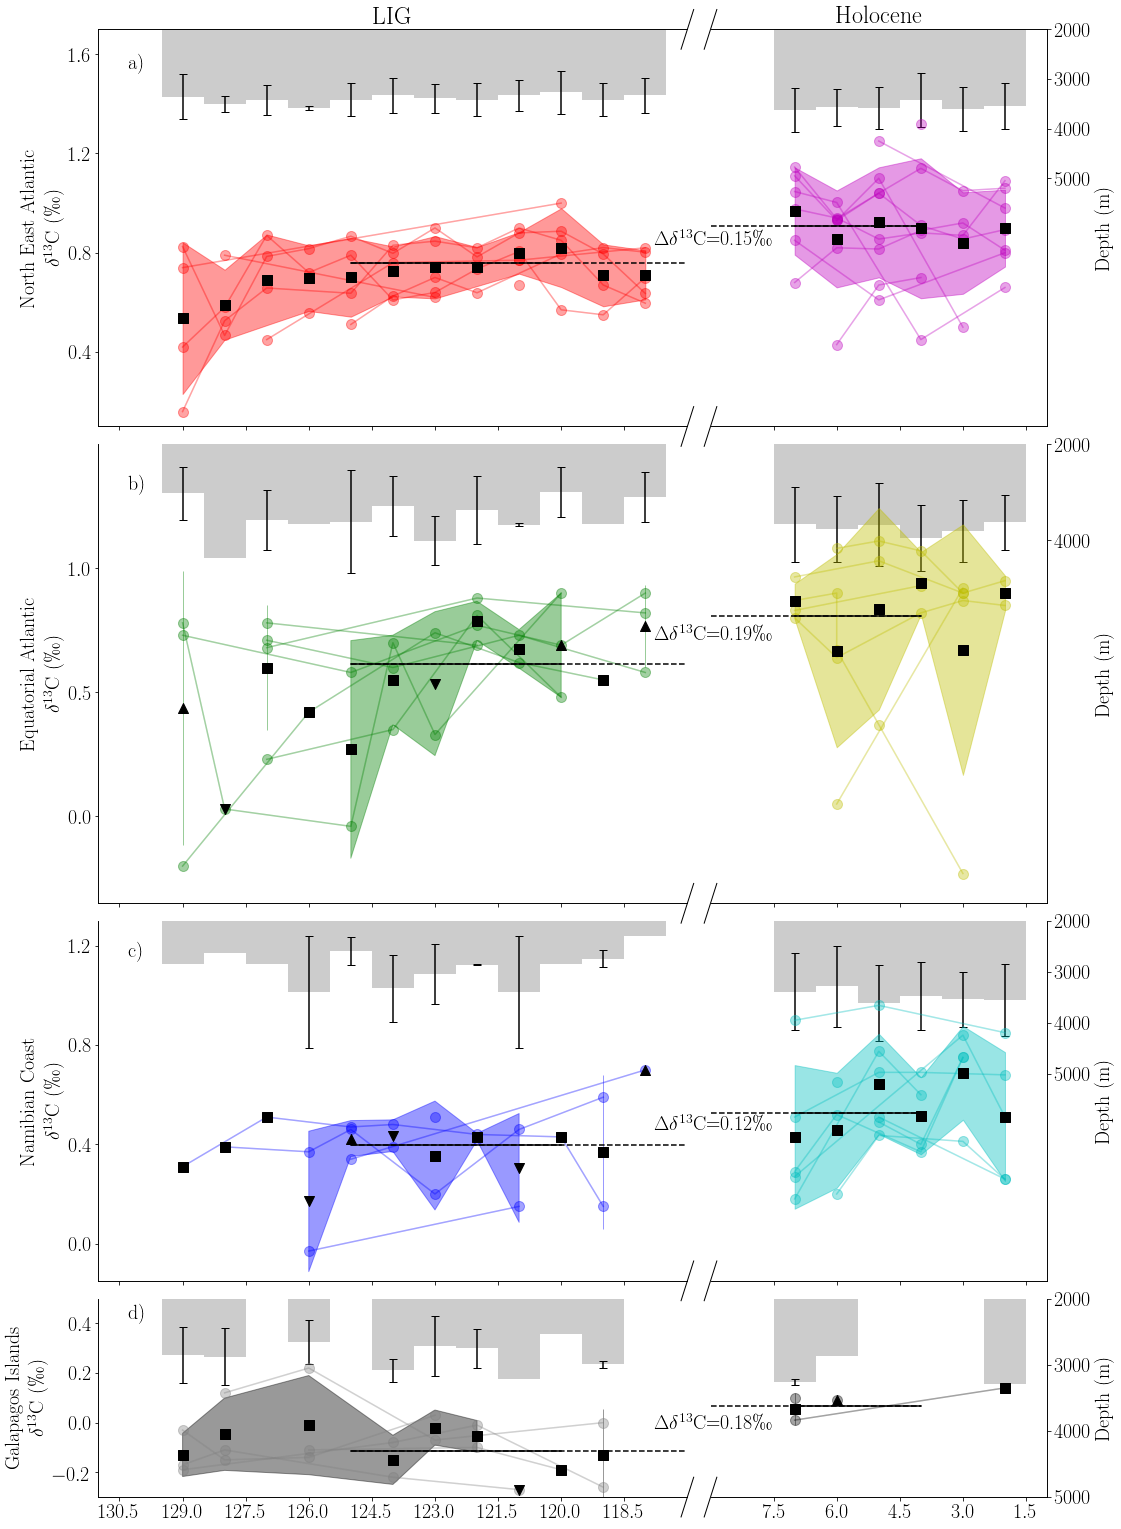

In [23]:

GA_Hol_color = 'k'

y_min1 = 0.1
y_max1 = 1.7
y_min2 = -0.35
y_max2 = 1.5
y_min3 = -0.15
y_max3 = 1.3
y_min4 = -0.3
y_max4 = 0.5

height_1 = float((y_max1 - y_min1))
height_2 = float((y_max2 - y_min2))
height_3 = float((y_max3 - y_min3))
height_4 = float((y_max4 - y_min4))

max_metres4 = float(5000)
metres_per_height = (max_metres4)/height_4

max_metres4 = height_4*metres_per_height
max_metres3 = height_3*metres_per_height
max_metres2 = height_2*metres_per_height
max_metres1 = height_1*metres_per_height

fig = plt.figure(figsize=(total_graph_width, 27))
plt.subplots_adjust(wspace=0.05,hspace=0.05)
gs = gridspec.GridSpec(4, 2, width_ratios=[width_lig, width_hol],
                       height_ratios=[height_1,height_2,height_3,height_4]) 

ax1D = plt.subplot(gs[0])
ax2D = plt.subplot(gs[1])
ax3D = plt.subplot(gs[2])
ax4D = plt.subplot(gs[3])
ax5D = plt.subplot(gs[4])
ax6D = plt.subplot(gs[5])
ax7D = plt.subplot(gs[6])
ax8D = plt.subplot(gs[7])


ax1C = ax1D.twinx()
ax2C = ax2D.twinx()
ax3C = ax3D.twinx()
ax4C = ax4D.twinx()
ax5C = ax5D.twinx()
ax6C = ax6D.twinx()
ax7C = ax7D.twinx()
ax8C = ax8D.twinx()

####################################################################################################
####################################################################################################
####################################################################################################

def deglaciation_plot(axC,axD,df,color,d13C_min,d13C_max,max_metres):

    #  Find the average stats
    averaged_points = df.groupby('lower').mean()
    stdev_points = df.groupby('lower').std()    
    
    #  Plot depth bars
    axD.bar(averaged_points.index, averaged_points.Ocean_depth,yerr=stdev_points.Ocean_depth,capsize=4,width=slice_width,zorder=-10000,color='0.8')

    unique_lats = np.unique(df['Lat'])
    years_list = np.unique(df.lower)

    interpolated_proxies = {}

    for unique_lat in unique_lats:

        # get a single proxy
        df_temp = df[df['Lat'] == unique_lat]

        axC.plot(df_temp.lower, df_temp.d13C, 'k', df_temp.lower, df_temp.d13C, c=color, alpha=0.2, ms=10, marker='o')
    
    # Plot the average of all the cores onto the same plot with stdev shaded region around it

    axC.fill_between(averaged_points.index,
                     averaged_points.d13C-stdev_points.d13C,
                     averaged_points.d13C+stdev_points.d13C,
                     zorder=-100,
                     color=color_format[0],
                     alpha=0.4)

    tol = 300
    df_shallow = averaged_points[averaged_points.Ocean_depth < (np.mean(df.Ocean_depth)-tol)]
    df_deep = averaged_points[averaged_points.Ocean_depth > (np.mean(df.Ocean_depth)+tol)]
    df_mid = averaged_points[(averaged_points.Ocean_depth < (np.mean(df.Ocean_depth))+tol) & (averaged_points.Ocean_depth > (np.mean(df.Ocean_depth)-tol))]
    
    for df_dep,marker in zip([df_shallow,df_mid,df_deep],['^','s','v']):
        axC.scatter(df_dep.index, df_dep.d13C, c='k',
                    marker=marker,
                    zorder=100,
                    s=100)
    
    # Axes adjust
    
    axC.set_ylim(d13C_min, d13C_max)
    axC.yaxis.set_label_position("left")
    axC.yaxis.tick_left()
    
    axD.set_ylim(max_metres, 2400)


    
####################################################################################################
####################################################################################################
####################################################################################################

cores_dfs = [NE_LIG_cores_deeper,
             NE_Hol_cores_deeper,
             MA_LIG_cores_deeper,
             MA_Hol_cores_deeper,
             NB_LIG_cores_deeper,
             NB_Hol_cores_deeper,
             GA_LIG_cores_deeper,
             GA_Hol_cores_deeper]

# ## Make axes the same
# d13C_list = pd.concat(cores_dfs).d13C
# d13C_min = np.min(d13C_list)
# d13C_max = np.max(d13C_list)
# d13C_min = -(math.trunc(-d13C_min) + math.ceil((-d13C_min)%1 * 4) /4)
# d13C_max = math.trunc(d13C_max) + math.ceil(d13C_max%1 * 4) /4

####################################################################################################
####################################################################################################
####################################################################################################

for axC,axD,df,color_format,d13C_min,d13C_max,max_metres in zip([ax1C,ax2C,ax3C,ax4C,ax5C,ax6C,ax7C,ax8C],
                                   [ax1D,ax2D,ax3D,ax4D,ax5D,ax6D,ax7D,ax8D],
                                   cores_dfs,
                                   [x for x in [NE_LIG_color,NE_Hol_color,MA_LIG_color,MA_Hol_color,NB_LIG_color,NB_Hol_color,GA_LIG_color,GA_Hol_color]],
                                   [y_min1,y_min1,y_min2,y_min2,y_min3,y_min3,y_min4,y_min4],
                                   [y_max1,y_max1,y_max2,y_max2,y_max3,y_max3,y_max4,y_max4],
                                   [max_metres1,max_metres1,max_metres2,max_metres2,max_metres3,max_metres3,max_metres4,max_metres4]
                                                    ):

    deglaciation_plot(axC,axD,df,color_format,d13C_min,d13C_max,max_metres)

for ax in [ax1C,ax3C,ax5C,ax7C]:
    ax.set_xlim(LIG_max+gap,LIG_min-gap)
for ax in [ax2C,ax4C,ax6C,ax8C]:
    ax.set_xlim(Hol_max+gap,Hol_min-gap)    
    
for ax in [ax2C,ax4C,ax6C,ax8C]:
    ax.get_xaxis().set_major_locator(MaxNLocator(nbins=(Hol_max-Hol_min),prune='both'))
    ax.get_yaxis().set_major_locator(MaxNLocator(nbins=4,prune='both'))

for ax in [ax1C,ax3C,ax5C,ax7C]:
    ax.get_xaxis().set_major_locator(MaxNLocator(nbins=(LIG_max-LIG_min),prune='both'))
    ax.get_yaxis().set_major_locator(MaxNLocator(nbins=4,prune='both'))        
    
for ax in [ax2D,ax4D,ax6D,ax8D]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
for ax in [ax1D,ax3D,ax5D,ax7D]:
    ax.get_yaxis().set_visible(False)
    
for ax in [ax2C,ax4C,ax6C,ax8C]:
    ax.get_yaxis().set_visible(False)
    
for ax in[ax1C,ax2C,ax3C,ax4C,ax5C,ax6C]:
    ax.set_xticklabels([])
    
for ax in [ax1C,ax3C,ax5C,ax7C]:
    ax.spines['right'].set_visible(False)

for ax in [ax2C,ax4C,ax6C,ax8C]:
    ax.spines['left'].set_visible(False) 
    
for ax in [ax3C,ax4C,ax5C,ax6C,ax7C,ax8C]:
    ax.spines['top'].set_visible(False)  
    
for ax in [ax1D,ax3D,ax5D,ax7D]:
    ax.spines['right'].set_visible(False)

for ax in [ax2D,ax4D,ax6D,ax8D]:
    ax.spines['left'].set_visible(False) 
    
for ax in [ax3D,ax4D,ax5D,ax6D,ax7D,ax8D]:
    ax.spines['top'].set_visible(False)    
    
ax1C.set_ylabel('North East Atlantic \n $\delta^{13}$C ($\permil$)')
ax3C.set_ylabel('Equatorial Atlantic \n $\delta^{13}$C ($\permil$)')
ax5C.set_ylabel('Namibian Coast \n $\delta^{13}$C ($\permil$)')
ax7C.set_ylabel('Galapagos Islands \n $\delta^{13}$C ($\permil$)')

ax2D.set_ylabel('Depth (m)')
ax4D.set_ylabel('Depth (m)')
ax6D.set_ylabel('Depth (m)')
ax8D.set_ylabel('Depth (m)')

ax1C.set_title('LIG')
ax2C.set_title('Holocene')

ax7C.set_xlabel('Time (kaBP)')
ax8C.set_xlabel('Time (kaBP)')

for ax,letter in zip([ax1C,ax3C,ax5C,ax7C],['a)','b)','c)','d)']):
    ax.text(ax.get_xlim()[0] + 0.05*np.diff(ax.get_xlim()),ax.get_ylim()[0] + 0.9*np.diff(ax.get_ylim()),letter)
    
for ax in [ax2D,ax4D,ax6D,ax8D]:
    ax.set_yticks([x for x in ax.get_yticks() if x<6000])
    
####################################################################################################

# ## Black dotted line drawing to the middle

def peak(df,min_age,max_age):
    df_peak = df[(df.lower >= min_age)&(df.lower <= max_age)]
    return(df_peak.d13C)

LIG_xmin = np.min(NE_LIG_cores_deeper.lower)
LIG_xmax = np.max(NE_LIG_cores_deeper.lower)
Hol_xmin = np.min(NE_Hol_cores_deeper.lower)
Hol_xmax = np.max(NE_Hol_cores_deeper.lower)

LIG_peak_min = 120
LIG_peak_max = 125
Hol_peak_min = 4
Hol_peak_max = 7

NE_peak_LIG = peak(NE_LIG_cores_deeper,LIG_peak_min,LIG_peak_max)
NE_peak_Hol = peak(NE_Hol_cores_deeper,Hol_peak_min,Hol_peak_max)
MA_peak_LIG = peak(MA_LIG_cores_deeper,LIG_peak_min,LIG_peak_max)
MA_peak_Hol = peak(MA_Hol_cores_deeper,Hol_peak_min,Hol_peak_max)
NB_peak_LIG = peak(NB_LIG_cores_deeper,LIG_peak_min,LIG_peak_max)
NB_peak_Hol = peak(NB_Hol_cores_deeper,Hol_peak_min,Hol_peak_max)
GA_peak_LIG = peak(GA_LIG_cores_deeper,LIG_peak_min,LIG_peak_max)
GA_peak_Hol = peak(GA_Hol_cores_deeper,Hol_peak_min,Hol_peak_max)

ax1C.plot([LIG_peak_max,LIG_peak_min], [np.mean(NE_peak_LIG),np.mean(NE_peak_LIG)], 'k-')
ax1C.plot([LIG_peak_max,ax1C.get_xlim()[1]], [np.mean(NE_peak_LIG),np.mean(NE_peak_LIG)], 'k--')
ax2C.plot([Hol_peak_max,Hol_peak_min], [np.mean(NE_peak_Hol),np.mean(NE_peak_Hol)], 'k-')
ax2C.plot([ax2C.get_xlim()[0],Hol_peak_min], [np.mean(NE_peak_Hol),np.mean(NE_peak_Hol)], 'k--')

ax3C.plot([LIG_peak_max,LIG_peak_min], [np.mean(MA_peak_LIG),np.mean(MA_peak_LIG)], 'k-')
ax3C.plot([LIG_peak_max,ax3C.get_xlim()[1]], [np.mean(MA_peak_LIG),np.mean(MA_peak_LIG)], 'k--')
ax4C.plot([Hol_peak_max,Hol_peak_min], [np.mean(MA_peak_Hol),np.mean(MA_peak_Hol)], 'k-')
ax4C.plot([ax4C.get_xlim()[0],Hol_peak_min], [np.mean(MA_peak_Hol),np.mean(MA_peak_Hol)], 'k--')

ax5C.plot([LIG_peak_max,LIG_peak_min], [np.mean(NB_peak_LIG),np.mean(NB_peak_LIG)], 'k-')
ax5C.plot([LIG_peak_max,ax5C.get_xlim()[1]], [np.mean(NB_peak_LIG),np.mean(NB_peak_LIG)], 'k--')
ax6C.plot([Hol_peak_max,Hol_peak_min], [np.mean(NB_peak_Hol),np.mean(NB_peak_Hol)], 'k-')
ax6C.plot([ax6C.get_xlim()[0],Hol_peak_min], [np.mean(NB_peak_Hol),np.mean(NB_peak_Hol)], 'k--')

ax7C.plot([LIG_peak_max,LIG_peak_min], [np.mean(GA_peak_LIG),np.mean(GA_peak_LIG)], 'k-')
ax7C.plot([LIG_peak_max,ax7C.get_xlim()[1]], [np.mean(GA_peak_LIG),np.mean(GA_peak_LIG)], 'k--')
ax8C.plot([Hol_peak_max,Hol_peak_min], [np.mean(GA_peak_Hol),np.mean(GA_peak_Hol)], 'k-')
ax8C.plot([ax8C.get_xlim()[0],Hol_peak_min], [np.mean(GA_peak_Hol),np.mean(GA_peak_Hol)], 'k--')

# # Calculate the delta, and write it on the plot

delta_NE = -np.mean(NE_peak_LIG) + np.mean(NE_peak_Hol)
delta_MA = -np.mean(MA_peak_LIG) + np.mean(MA_peak_Hol)
delta_NB = -np.mean(NB_peak_LIG) + np.mean(NB_peak_Hol)
delta_GA = -np.mean(GA_peak_LIG) + np.mean(GA_peak_Hol)

text_NE = r'$\Delta\delta^{13}$C='+str(np.trunc(delta_NE*100)/100)+r'$\permil$'
text_MA = r'$\Delta\delta^{13}$C='+str(np.trunc(delta_MA*100)/100)+r'$\permil$'
text_NB = r'$\Delta\delta^{13}$C='+str(np.trunc(delta_NB*100)/100)+r'$\permil$'
text_GA = r'$\Delta\delta^{13}$C='+str(np.trunc(delta_GA*100)/100)+r'$\permil$'

ax2C.text(ax2C.get_xlim()[0]*1.15,np.mean([np.mean(NE_peak_Hol),np.mean(NE_peak_LIG)]), text_NE)
ax4C.text(ax4C.get_xlim()[0]*1.15,np.mean([np.mean(MA_peak_Hol),np.mean(MA_peak_LIG)]), text_MA)
ax6C.text(ax6C.get_xlim()[0]*1.15,np.mean([np.mean(NB_peak_Hol),np.mean(NB_peak_LIG)]), text_NB)
ax8C.text(ax8C.get_xlim()[0]*1.15,np.mean([np.mean(GA_peak_Hol),np.mean(GA_peak_LIG)]), text_GA)

####################################################################################################
####################################################################################################

# All x axis (bottom)

d = 0.15

hol_x = ax2C.get_xlim()[0]
lig_x = ax1C.get_xlim()[1]

y_frac = np.diff(ax1C.get_ylim())*0.05

for x,ax in zip([hol_x,lig_x,hol_x,lig_x,hol_x,lig_x,hol_x,lig_x],
                  [ax2C,ax1C,ax4C,ax3C,ax6C,ax5C,ax8C,ax7C]):

    y_min = ax.get_ylim()[0]

    line = lines.Line2D([loc+x for loc in [-d,d]],
             [y_min+y_frac,y_min-y_frac],c='k',linewidth=1)
    
    line.set_clip_on(False)
    ax.add_line(line)  

# Run for just top x axis
y_max = ax2C.get_ylim()[1]
    
line = lines.Line2D([loc+hol_x for loc in [-d,d]],
         [y_max+y_frac,y_max-y_frac],c='k',linewidth=1)
line.set_clip_on(False)
ax2C.add_line(line)   
line = lines.Line2D([loc+lig_x for loc in [-d,d]],
         [y_max+y_frac,y_max-y_frac],c='k',linewidth=1)
line.set_clip_on(False)
ax1C.add_line(line)
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.savefig('../Figures/Regional_comparison.png',bbox_inches='tight')

plt.show()


In [17]:
caption = [
    'Benthic foraminifera $\delta^{13}$C (left y-axis, $\permil$) during the Holocene and LIG for four defined regions;',
    'North East Atlantic (a, b) , Equatorial Atlantic (c, d), Namibian Coast (e, f) , and Galapagos Islands (g, h).',
    'Data is presented in discrete time slices spanning {} years,'.format(slice_width*1000),
    'only including cores deeper than {}m.'.format(dividing_depth),
    'Circular, transparent points connected by lines are individual proxies.',
    'Black points represent $\delta^{13}$C averages per slice.',
    'Each slice has a corresponding averaged depth (right y-axis, m), with 1 standard deviation either side shown in the bars.',
    'Slices with an average depth within $\pm${}m of the mean core depth of all slices are represented with a square point.'.format(tol),
    'Slices with an average depth shallower than {}m are shown in a upward triangle, and deeper than {}m are shown in a downward triangle.'.format(tol,tol),
    'Shading shows 1 standard deviation either side of the mean for slices where more than 1 point exists.'
]

caption = ' '.join(caption)

# Write to a file
file1 = open("../Figures/Regional_comparison_caption.tex","w") 
file1.write(caption) 
file1.close() #to change file access modes

# Deeper cores T-test

In [18]:
# Run and view the results of the t-test
print('North East Atlantic P-value: {}'.format(stats.ttest_ind(NE_Hol_cores_deeper.d13C, NE_LIG_cores_deeper.d13C).pvalue))
print('Mid Atlantic P-value: {}'.format(stats.ttest_ind(MA_Hol_cores_deeper.d13C, MA_LIG_cores_deeper.d13C).pvalue))
print('Namibian Coast P-value: {}'.format(stats.ttest_ind(NB_Hol_cores_deeper.d13C, NB_LIG_cores_deeper.d13C).pvalue))
print('Galapagos Islands P-value: {}'.format(stats.ttest_ind(NB_Hol_cores_deeper.d13C, NB_LIG_cores_deeper.d13C).pvalue))


North East Atlantic P-value: 1.8529006537371194e-06
Mid Atlantic P-value: 0.02035687461902947
Namibian Coast P-value: 0.010961795270403966
Galapagos Islands P-value: 0.010961795270403966


In [26]:
summary_table_dict = {}
for region,df_hol,df_lig,lat_min,lat_max,lon_min,lon_max in zip(
    ['North East Atlantic', 'Equatorial Atlantic', 'Namibian Coast', 'Galapagos Islands'],
    [NE_peak_Hol, MA_peak_Hol, NB_peak_Hol, GA_peak_Hol],
    [NE_peak_LIG, MA_peak_LIG, NB_peak_LIG, GA_peak_LIG],
    [NE_lat_min, MA_lat_min, NB_lat_min, GA_lat_min],
    [NE_lat_max, MA_lat_max, NB_lat_max, GA_lat_max],
    [NE_lon_min, MA_lon_min, NB_lon_min, GA_lon_min],
    [NE_lon_max, MA_lon_max, NB_lon_max, GA_lon_max]    
                 ):
    
    lat_min = [str(lat_min)+'N' if lat_min > 0 else str(-lat_min)+'S'][0]
    lat_max = [str(lat_max)+'N' if lat_max > 0 else str(-lat_max)+'S'][0]   
    lon_min = [str(lon_min)+'W' if lon_min > 0 else str(-lon_min)+'E'][0]
    lon_max = [str(lon_max)+'W' if lon_max > 0 else str(-lon_max)+'E'][0]      
    
    summary_table_dict.update({
        region : {
            'Latitude' : '{}-{}'.format(lat_min,lat_max),
            'Longitude' : '{}-{}'.format(lon_min,lon_max),            
            'Holocene average d13C' : round(np.mean(df_hol),2),
            'LIG average d13C' : round(np.mean(df_lig),2),
            'dd13C' : round(np.mean(df_hol) - np.mean(df_lig),2),
            'P value' : round(stats.ttest_ind(df_hol, df_lig).pvalue,4)
        }
    })
    
df_summary_table = pd.DataFrame.from_dict(summary_table_dict,orient='index')
df_summary_table = df_summary_table.reset_index(drop=False).rename(columns={'index': 'Region'})
df_summary_table

,Region,Latitude,Longitude,Holocene average d13C,LIG average d13C,dd13C,P value
0,North East Atlantic,41N-58N,32E-15E,0.91,0.76,0.15,0.0017
1,Equatorial Atlantic,7S-3N,18E-5E,0.81,0.61,0.19,0.0488
2,Namibian Coast,28S-18S,4W-15W,0.52,0.40,0.13,0.0786
3,Galapagos Islands,5S-6N,98E-82E,0.07,-0.11,0.18,0.0204


In [27]:
# Convert to string of latex markdown
latex_string = df_summary_table.to_latex(index=False,longtable=True)

# Reformat some parts of the latex table
latex_string = latex_string.replace('\\toprule','')
latex_string = latex_string.replace('\\midrule','')
latex_string = latex_string.replace('\\bottomrule','')

# Add caption to latex table
caption = [
    '\caption{Regional summaries of $\delta^{13}$C slice averages,',
    'the Holocene - LIG difference ($\Delta\delta^{13}$C) '
    'and results of a two-sample T-test between the two time periods.}'
]

caption = ' '.join(caption)

latex_string = latex_string.replace('\\end{longtable}',caption+'\\end{longtable}')
latex_string = latex_string.replace('dd13C','$\Delta\delta^{13}C$')
latex_string = latex_string.replace('d13C','$\delta^{13}$C')

# Write to a file
file1 = open("../Figures/regional_summary_table.tex","w") 
file1.write(latex_string) 
file1.close()
  